# Segment Anything Model 2.1 (SAM2.1) - Parameter Tuning 

This notebook demonstrates how to use Meta's Segment Anything Model 2.1 (SAM2.1) for image segmentation and experiment with different parameter configurations to optimize results for faba bean images.

Author: Harpreet Kaur Bargota

Email: harpreet.bargota@agr.gc.ca

## Overview
- Load and use SAM2.1 for automatic mask generation
- Experiment with different parameters
- Visualize segmentation results
- Compare performance across parameter sets

## 1. Installation and Setup

In [1]:
# Install required packages
# !pip install segment-anything opencv-python matplotlib pillow torch torchvision numpy --break-system-packages

In [2]:
# Import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
# import requests
from io import BytesIO
import os
import time

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cu128
CUDA available: True


## 2. Download SAM Model Checkpoint

In [ ]:

#import the required libraries
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator


#specify the model configs and checkpoints
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"


## 3. Load Model and Image

In [4]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load SAM model
# use sam predictor for generating masks
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device) 

sam2_model.to(device="cpu")

print("SAM model loaded successfully!")

Using device: cuda
SAM model loaded successfully!


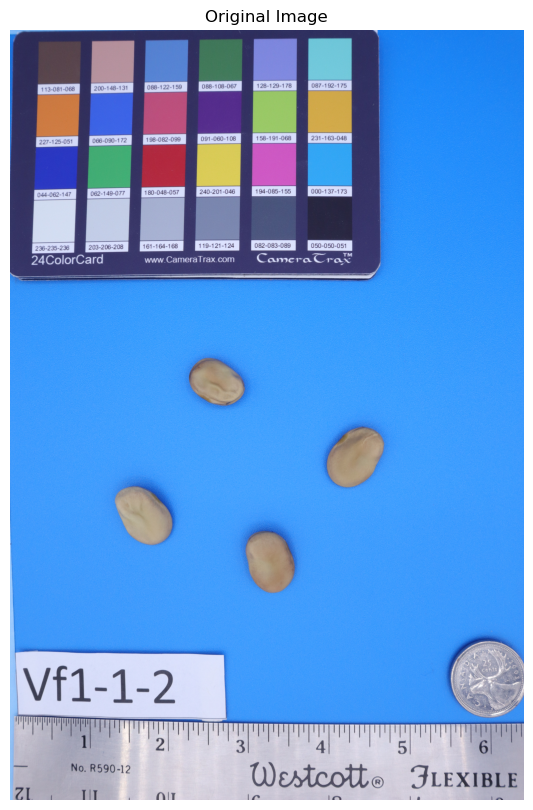

Image shape: (6000, 4000, 3)


In [ ]:
# Load the image
image = load_image_from_file("/home/AGR.GC.CA/bargotah/hkb/faba_image/Faba-Seed-CC_Vf1-1-2.JPG")

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')
plt.show()

print(f"Image shape: {image.shape}")

## 4. Helper Functions for Visualization

In [6]:
def show_anns(anns, ax=None):
    """Display annotations with different colors for each mask"""
    if len(anns) == 0:
        return
    
    if ax is None:
        ax = plt.gca()
    
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], 
                   sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
    
    ax.imshow(img)

def show_masks_on_image(image, masks, scores=None, point_coords=None):
    """Display masks overlaid on the original image"""
    fig, axes = plt.subplots(1, len(masks) + 1, figsize=(15, 5))
    
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    for i, (mask, ax) in enumerate(zip(masks, axes[1:])):
        ax.imshow(image)
        ax.imshow(mask, alpha=0.5, cmap='jet')
        if scores is not None:
            ax.set_title(f'Mask {i+1} (Score: {scores[i]:.3f})')
        else:
            ax.set_title(f'Mask {i+1}')
        
        if point_coords is not None:
            ax.plot(point_coords[0], point_coords[1], 'r*', markersize=15)
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def compare_segmentations(image, results_dict):
    """Compare multiple segmentation results side by side"""
    n_results = len(results_dict)
    fig, axes = plt.subplots(1, n_results + 1, figsize=(5 * (n_results + 1), 5))
    
    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Segmentation results
    for idx, (name, masks) in enumerate(results_dict.items(), 1):
        axes[idx].imshow(image)
        show_anns(masks, ax=axes[idx])
        axes[idx].set_title(f'{name}\n({len(masks)} masks)', fontsize=10)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

## 5. Automatic Mask Generation with Default Parameters

Number of masks generated: 72
Time taken: 54.67 seconds

Mask properties: dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


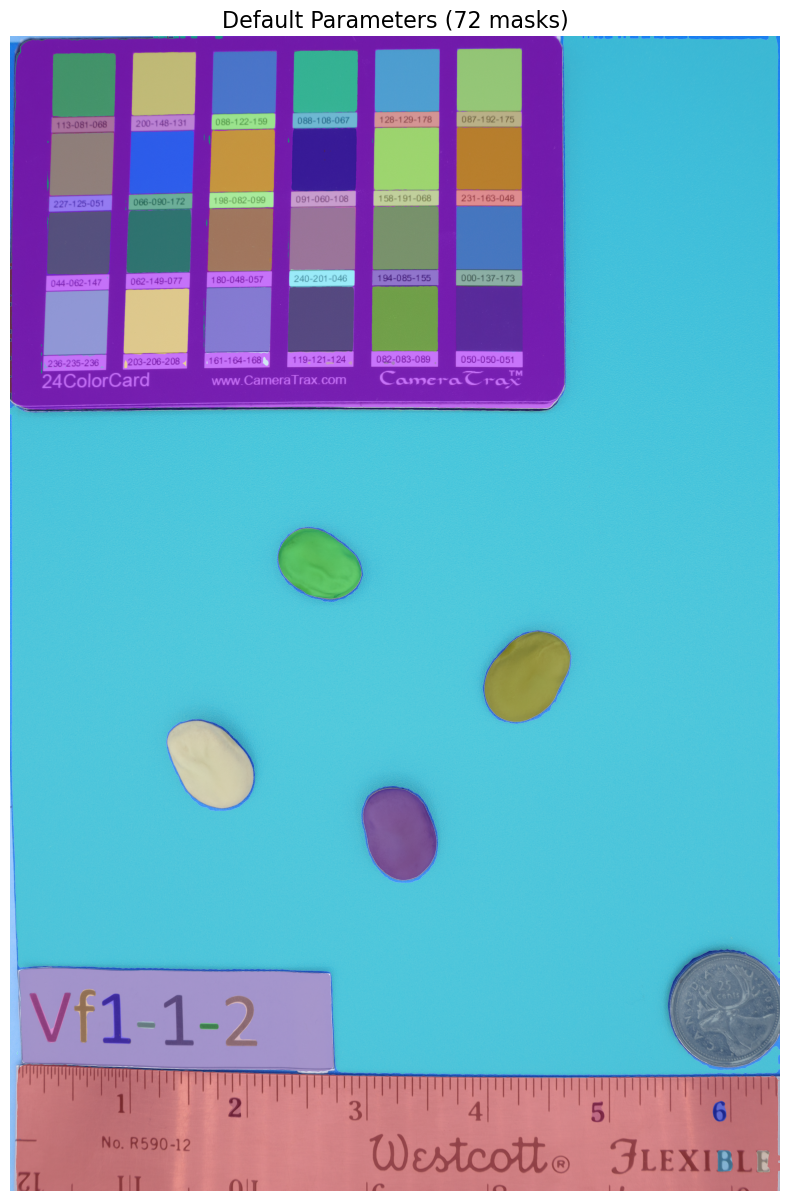

In [7]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
# Generate masks
start_time = time.time()

mask_generator = SAM2AutomaticMaskGenerator(sam2_model)
masks_default = mask_generator.generate(image)

elapsed_time = time.time() - start_time

print(f"Number of masks generated: {len(masks_default)}")
print(f"Time taken: {elapsed_time:.2f} seconds")
print(f"\nMask properties: {masks_default[0].keys() if masks_default else 'No masks'}")

# Visualize
plt.figure(figsize=(15, 15))
plt.imshow(image)
show_anns(masks_default)
plt.axis('off')
plt.title(f'Default Parameters ({len(masks_default)} masks)', fontsize=16)
plt.show()

## 6. Parameter Tuning Experiments

### Key Parameters:
- **points_per_side**: Number of points sampled along each side of the image (higher = more masks)
- **pred_iou_thresh**: IoU threshold for filtering low-quality masks (higher = fewer but better masks)
- **stability_score_thresh**: Stability threshold for mask quality (higher = more stable masks)
- **crop_n_layers**: Number of layers for crop-based generation (more layers = better for small objects)
- **min_mask_region_area**: Minimum area for valid masks (filters out tiny segments)

### Experiment 1: Varying points_per_side


Testing points_per_side=16


Generated 43 masks in 18.32s

Testing points_per_side=32
Generated 72 masks in 55.61s

Testing points_per_side=64
Generated 94 masks in 210.04s


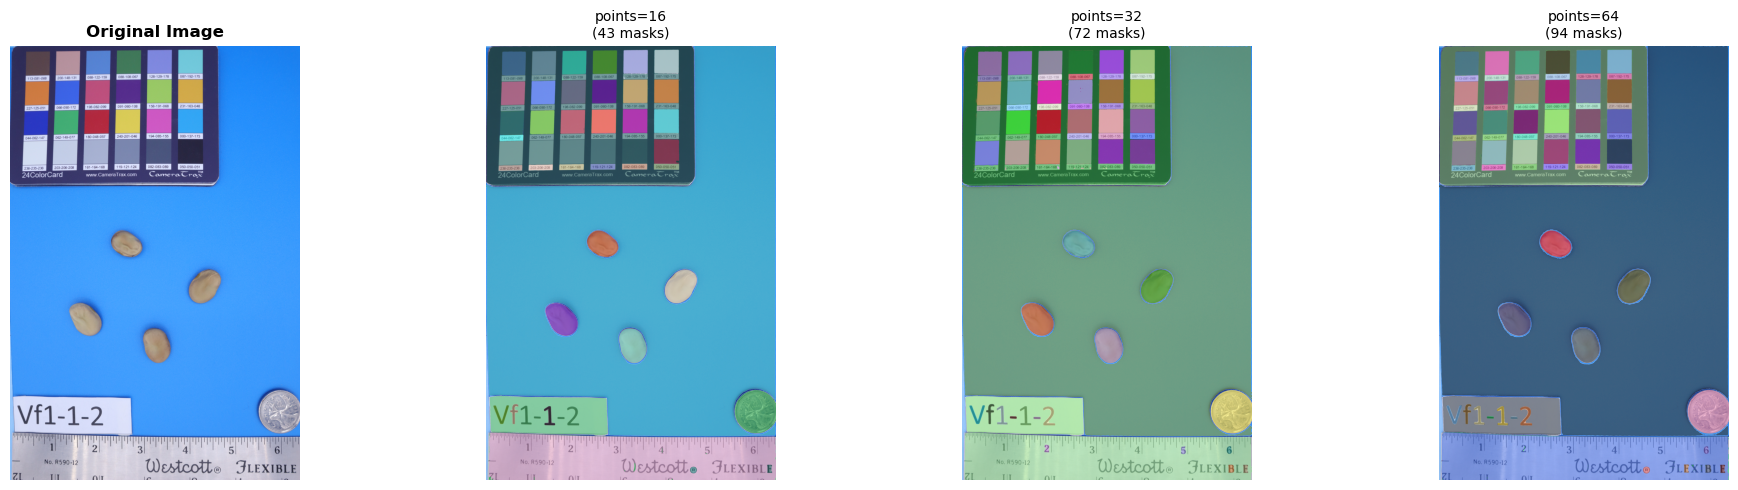

In [8]:
# Test different points_per_side values
points_per_side_values = [16, 32, 64]
results_points = {}

for points in points_per_side_values:
    print(f"\nTesting points_per_side={points}")

    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2_model,
        points_per_side=points,
    )
    
    start_time = time.time()
    masks = mask_generator.generate(image)
    elapsed_time = time.time() - start_time
    
    results_points[f"points={points}"] = masks
    print(f"Generated {len(masks)} masks in {elapsed_time:.2f}s")

# Compare results
compare_segmentations(image, results_points)

Results:	
1. Points per side = 16: Generated the fewest masks, capturing coarse object boundaries. Computation was fastest, but some smaller or partially occluded objects were missed.
2. Points per side = 32: Produced a higher number of masks with better coverage of object boundaries, including smaller and partially occluded seeds. Computation time increased moderately.
3. Points per side = 64: Generated the highest number of masks and detailed segmentations; however, the processing time increased substantially, with diminishing gains in segmentation quality compared to 32 points per side.
Based on these results, points_per_side = 32 was identified as the optimal setting. It provided a balance between segmentation accuracy and computational efficiency, capturing most objects reliably without excessive processing time.


### Experiment 2: Varying points_per_batch


Testing points_per_batch=32
Generated 72 masks in 51.62s

Testing points_per_batch=64
Generated 72 masks in 48.51s

Testing points_per_batch=128
Generated 72 masks in 47.17s


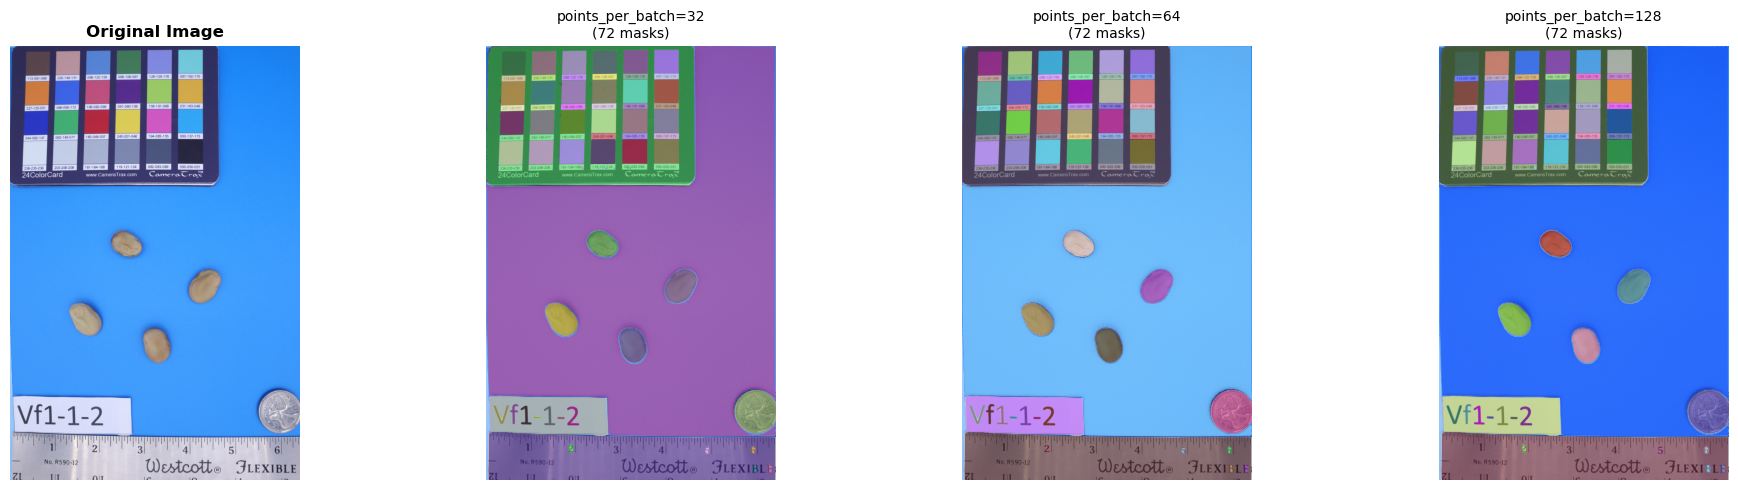

In [10]:
# points per batch
points_per_batch_values = [32, 64, 128]
results_ppb = {}

for ppb in points_per_batch_values:
    print(f"\nTesting points_per_batch={ppb}")

    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2_model,
        points_per_batch=ppb,
    )

    start_time = time.time()
    masks = mask_generator.generate(image)
    elapsed_time = time.time() - start_time

    results_ppb[f"points_per_batch={ppb}"] = masks
    print(f"Generated {len(masks)} masks in {elapsed_time:.2f}s")

# Compare results
compare_segmentations(image, results_ppb)



Results:
Three values were tested: 32, 64, and 128. Across all settings, the total number of generated masks remained identical (72 masks), indicating that points_per_batch does not influence segmentation quality or object detection. However, computation time decreased as the batch size increased. Processing 32 points per batch required 51.62 s, while increasing the batch size to 64 reduced the time to 48.51 s. The fastest performance was achieved with 128 points per batch, completing in 47.17 s. These results demonstrate that larger batch sizes improve computational efficiency without affecting segmentation output, making points_per_batch = 128 the most efficient setting for our dataset.

### Experiment 3: Varying pred_iou_thresh


Testing pred_iou_thresh=0.7


Generated 74 masks in 48.52s

Testing pred_iou_thresh=0.86
Generated 71 masks in 47.07s

Testing pred_iou_thresh=0.95
Generated 56 masks in 47.12s


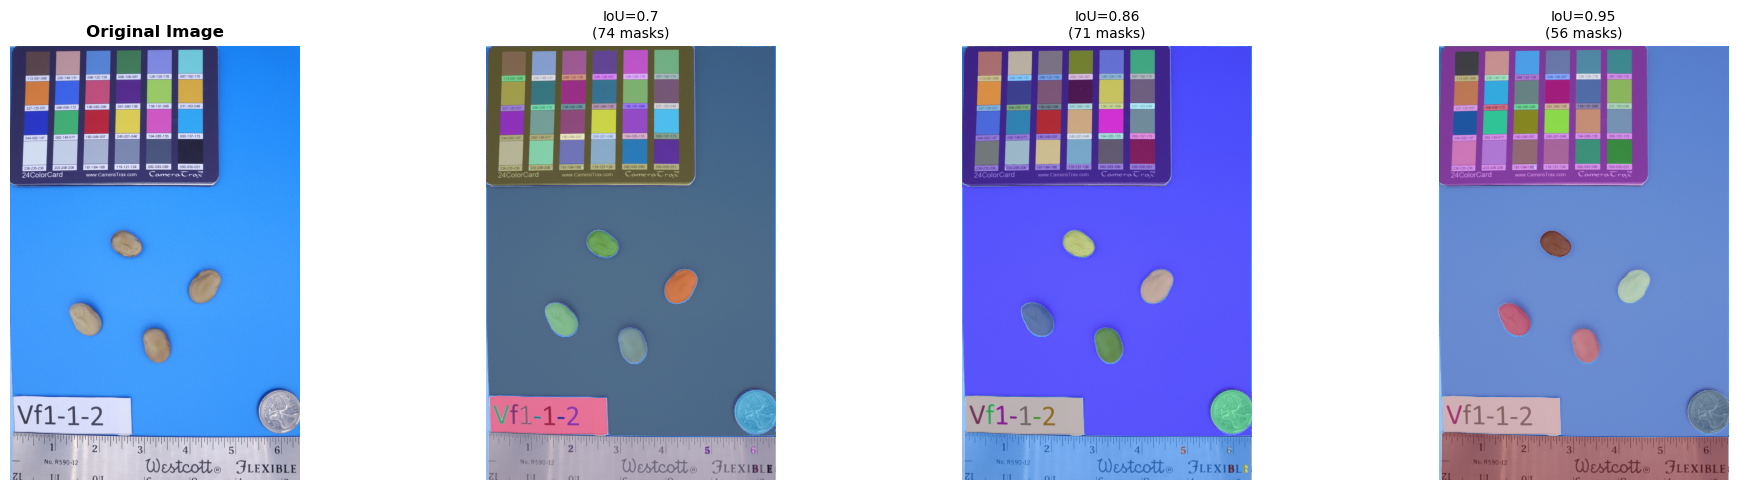

In [11]:
# Test different pred_iou_thresh values
iou_thresh_values = [0.7, 0.86, 0.95]
results_iou = {}

for iou_thresh in iou_thresh_values:    

    print(f"\nTesting pred_iou_thresh={iou_thresh}")
    
    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2_model,
        pred_iou_thresh=iou_thresh,
    )
    
    start_time = time.time()
    masks = mask_generator.generate(image)
    elapsed_time = time.time() - start_time
    
    results_iou[f"IoU={iou_thresh}"] = masks
    print(f"Generated {len(masks)} masks in {elapsed_time:.2f}s")

# Compare results
compare_segmentations(image, results_iou)

Results: 

Increasing this threshold progressively reduced the number of masks retained, reflecting stricter filtering of low-IoU or low-quality predictions. At a threshold of 0.70, the model generated 74 masks, representing the least restrictive filtering. Raising the threshold to 0.86 reduced the output to 71 masks, while the highest threshold (0.95) resulted in only 56 masks. Computation time remained nearly constant across settings (47–49 s), indicating that the parameter mainly affects post-prediction filtering rather than processing cost. Overall, higher IoU thresholds improve mask precision by removing less reliable predictions, but may also discard valid masks, whereas lower thresholds retain more masks at the expense of including lower-quality segmentations. For our dataset, the intermediate value (0.86) provided a balance between retaining sufficient masks and reducing noise.

### Experiment 4: Varying stability_score_thresh


Testing stability_score_thresh=0.8


Generated 79 masks in 58.21s

Testing stability_score_thresh=0.92
Generated 78 masks in 46.57s

Testing stability_score_thresh=0.98
Generated 26 masks in 42.24s


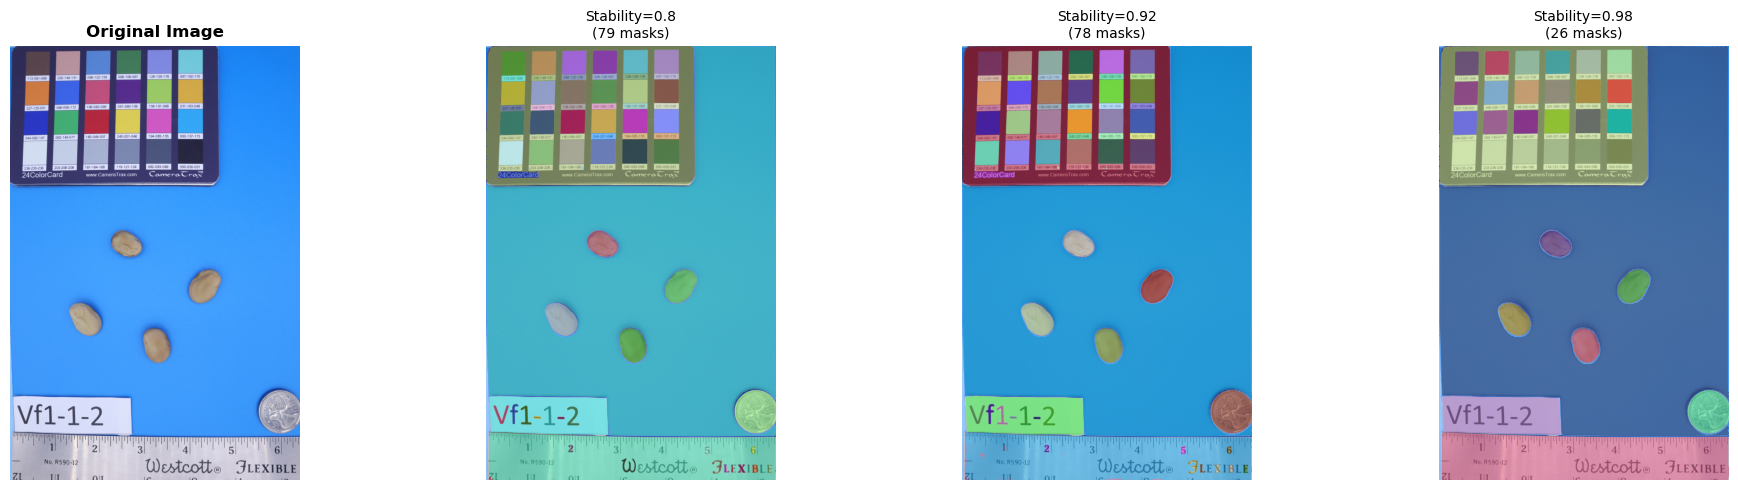

In [12]:
# Test different stability_score_thresh values
stability_values = [0.80, 0.92, 0.98]
results_stability = {}

for stability in stability_values:
    print(f"\nTesting stability_score_thresh={stability}")
    
    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2_model,
        stability_score_thresh=stability,
    )
    
    start_time = time.time()
    masks = mask_generator.generate(image)
    elapsed_time = time.time() - start_time
    
    results_stability[f"Stability={stability}"] = masks
    print(f"Generated {len(masks)} masks in {elapsed_time:.2f}s")

# Compare results
compare_segmentations(image, results_stability)

Result:

We investigated the influence of the stability_score_thresh parameter, which controls the minimum stability required for a mask to be retained. Lower thresholds accept less stable masks, whereas higher thresholds enforce stricter consistency requirements. At a threshold of 0.80, the model produced 79 masks, the highest among the tested values, although this setting also included masks with lower stability. Increasing the threshold to 0.92 resulted in a slight reduction to 78 masks, while maintaining comparable segmentation detail and reducing computation time (46.57 s vs. 58.21 s). The strictest threshold, 0.98, substantially filtered out unstable predictions, yielding only 26 masks with the shortest computation time (42.24 s). These results show that higher stability thresholds remove a significant proportion of masks—particularly those with ambiguous boundaries—leading to cleaner but more conservative segmentations, whereas lower thresholds preserve more objects at the risk of including unstable mask predictions. The intermediate value (0.92) offered the best balance between stability filtering and retaining meaningful segmentations for our dataset.

### Experiment 5: Varying poinbox_nms_thresh


Testing box_nms_thresh=0.5
Generated 67 masks in 43.46s

Testing box_nms_thresh=0.7
Generated 72 masks in 48.97s

Testing box_nms_thresh=0.9
Generated 86 masks in 56.42s


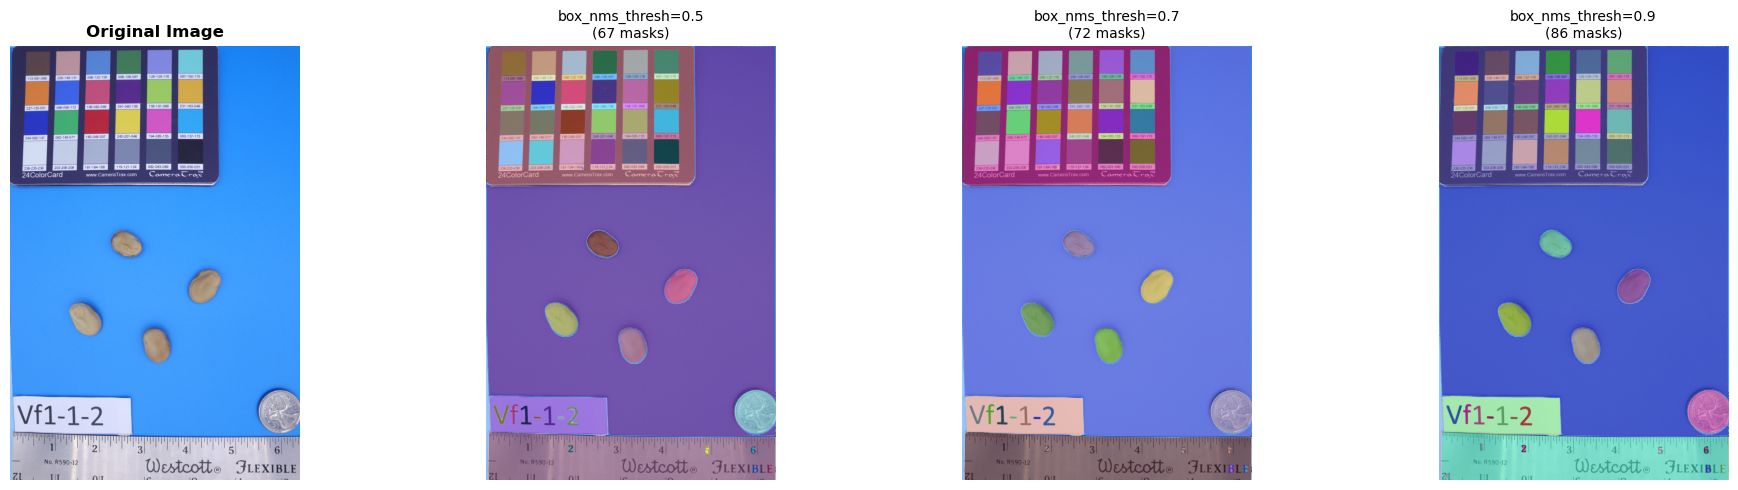

In [14]:
# box nums thresh
box_nms_thresh_values = [0.5, 0.7, 0.9]
results_box_nms = {}

for thresh in box_nms_thresh_values:
    print(f"\nTesting box_nms_thresh={thresh}")

    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2_model,
        box_nms_thresh=thresh,
    )

    start_time = time.time()
    masks = mask_generator.generate(image)
    elapsed_time = time.time() - start_time

    results_box_nms[f"box_nms_thresh={thresh}"] = masks
    print(f"Generated {len(masks)} masks in {elapsed_time:.2f}s")

# Compare results
compare_segmentations(image, results_box_nms)


Result: 

Lower values enforce stronger suppression, reducing redundancy, while higher values allow more overlapping detections to be retained. At a threshold of 0.50, the model generated 67 masks, reflecting aggressive suppression of overlapping regions and removal of many partially redundant predictions. Increasing the threshold to 0.70 resulted in 72 masks, indicating more permissive handling of overlaps while maintaining moderate suppression. The highest threshold, 0.90, produced 86 masks—the largest number among the tested settings—demonstrating that minimal suppression allows many overlapping or closely adjacent predictions to be preserved. Computation time increased progressively from 43.46 s at 0.50 to 56.42 s at 0.90, reflecting the higher number of masks retained. Overall, lower thresholds effectively reduce redundant masks, while higher thresholds increase mask count but may introduce overlap-related noise. The intermediate setting (0.70) provided a balanced trade-off for our dataset.

### Experiment 6: Varying min_mask_region_area


Testing min_mask_region_area=0


Generated 72 masks in 53.17s

Testing min_mask_region_area=100


/data/home/AGR.GC.CA/bargotah/faba-bean-FE-pipeline/sam2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/data/home/AGR.GC.CA/bargotah/faba-bean-FE-pipeline/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


Generated 72 masks in 55.64s

Testing min_mask_region_area=500
Generated 72 masks in 53.43s


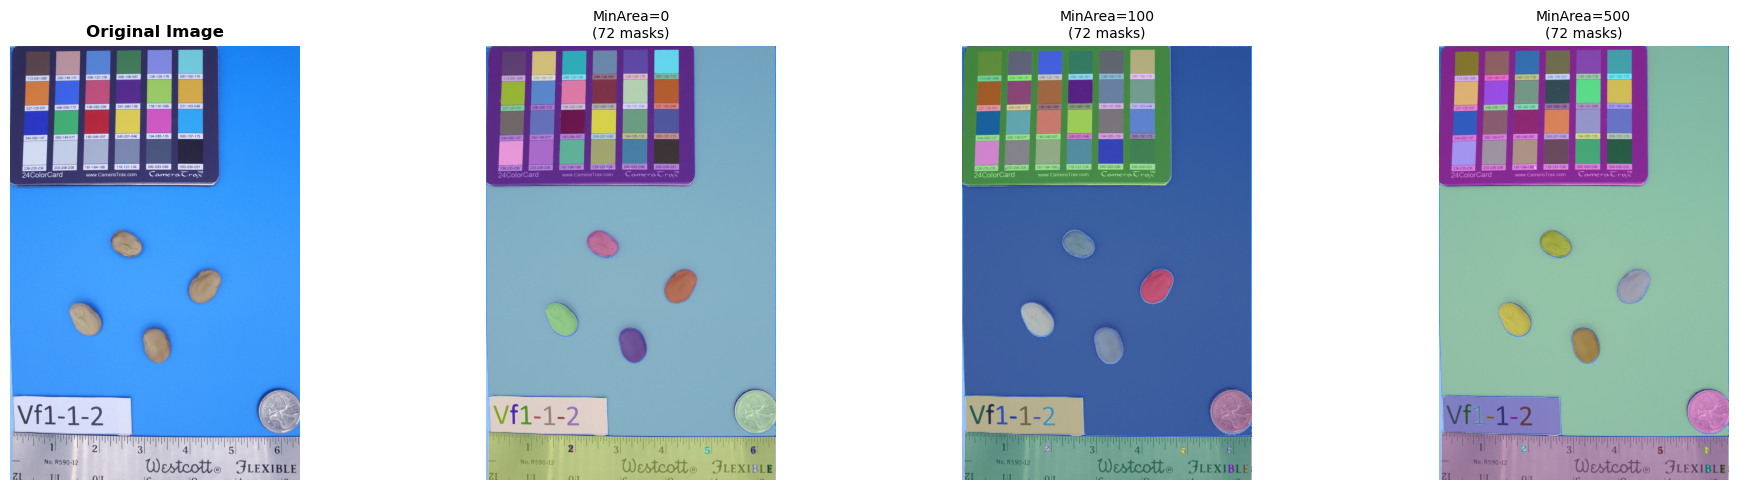

In [15]:
# Test different min_mask_region_area values
min_area_values = [0, 100, 500]
results_area = {}

for min_area in min_area_values:
    print(f"\nTesting min_mask_region_area={min_area}")
    
    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2_model,
        min_mask_region_area=min_area,
    )
    
    start_time = time.time()
    masks = mask_generator.generate(image)
    elapsed_time = time.time() - start_time
    
    results_area[f"MinArea={min_area}"] = masks
    print(f"Generated {len(masks)} masks in {elapsed_time:.2f}s")

# Compare results
compare_segmentations(image, results_area)

Across all settings, the model consistently produced 72 masks, indicating that the objects in our dataset were sufficiently large and were not affected by the minimum-area filtering. Computation times remained similar, ranging from 53.17 s at a threshold of 0 to 55.64 s at 100 pixels and 53.43 s at 500 pixels. Consequently, this parameter did not play a meaningful role in mask filtering for faba bean seed images.

### Experiment 7: Varying crop_nms_thresh


Testing crop_nms_thresh=0.5
Generated 72 masks in 53.27s

Testing crop_nms_thresh=0.7
Generated 72 masks in 51.01s

Testing crop_nms_thresh=0.9
Generated 72 masks in 56.97s


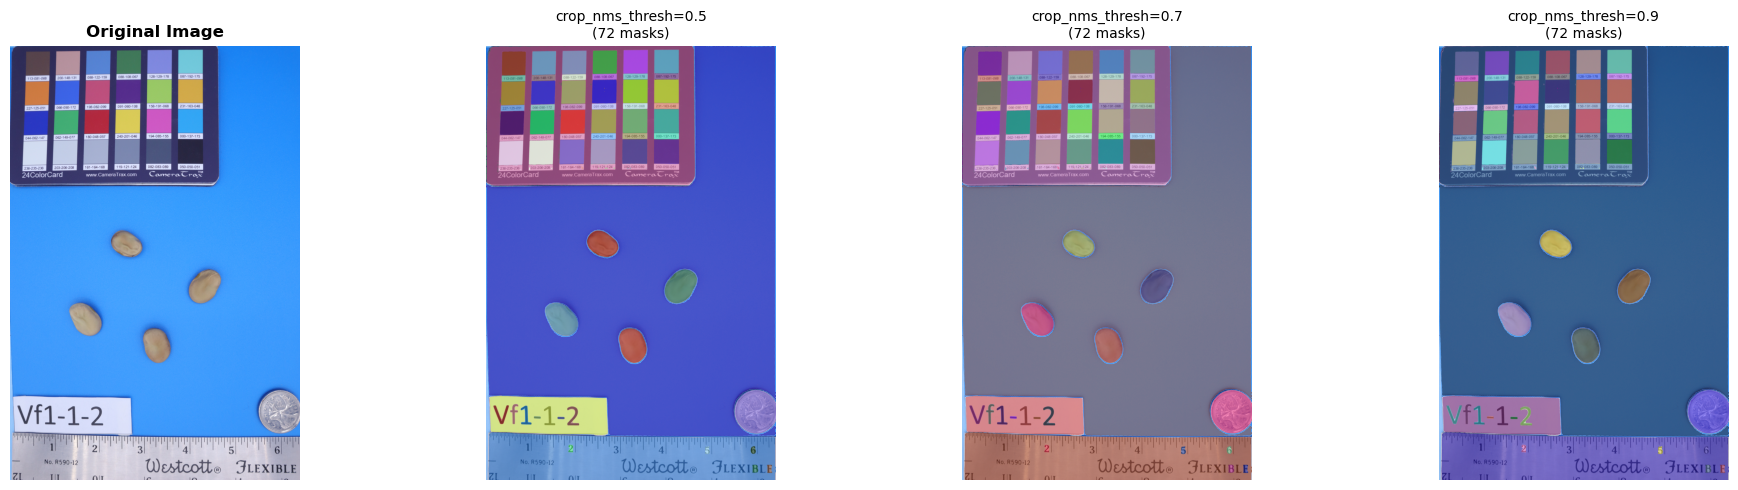

In [17]:
#  crop nms thresh
crop_nms_thresh_values = [0.5, 0.7, 0.9]
results_crop_nms = {}

for thresh in crop_nms_thresh_values:
    print(f"\nTesting crop_nms_thresh={thresh}")

    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2_model,
        crop_nms_thresh=thresh,
    )

    start_time = time.time()
    masks = mask_generator.generate(image)
    elapsed_time = time.time() - start_time

    results_crop_nms[f"crop_nms_thresh={thresh}"] = masks
    print(f"Generated {len(masks)} masks in {elapsed_time:.2f}s")

# Compare results
compare_segmentations(image, results_crop_nms)


Across all values, the model consistently produced 72 masks, indicating that adjustments to this parameter did not influence the number of retained segmentations for our dataset. Computation times showed only minor fluctuations, ranging from 51.01 s (0.7 threshold) to 56.97 s (0.9 threshold), with no clear performance trend. These results suggest that crop_nms_thresh has minimal impact on segmentation outcomes for the faba bean images, likely because object boundaries were sufficiently distinct and non-overlapping across crop regions. Therefore, this parameter did not provide meaningful advantages for improving segmentation quality in our dataset.

## 7. Optimized Parameter Configuration


Testing High Quality configuration...


Generated 121 masks in 313.25s

Testing Balanced configuration...
Generated 75 masks in 53.89s

Testing Fast configuration...
Generated 41 masks in 14.25s


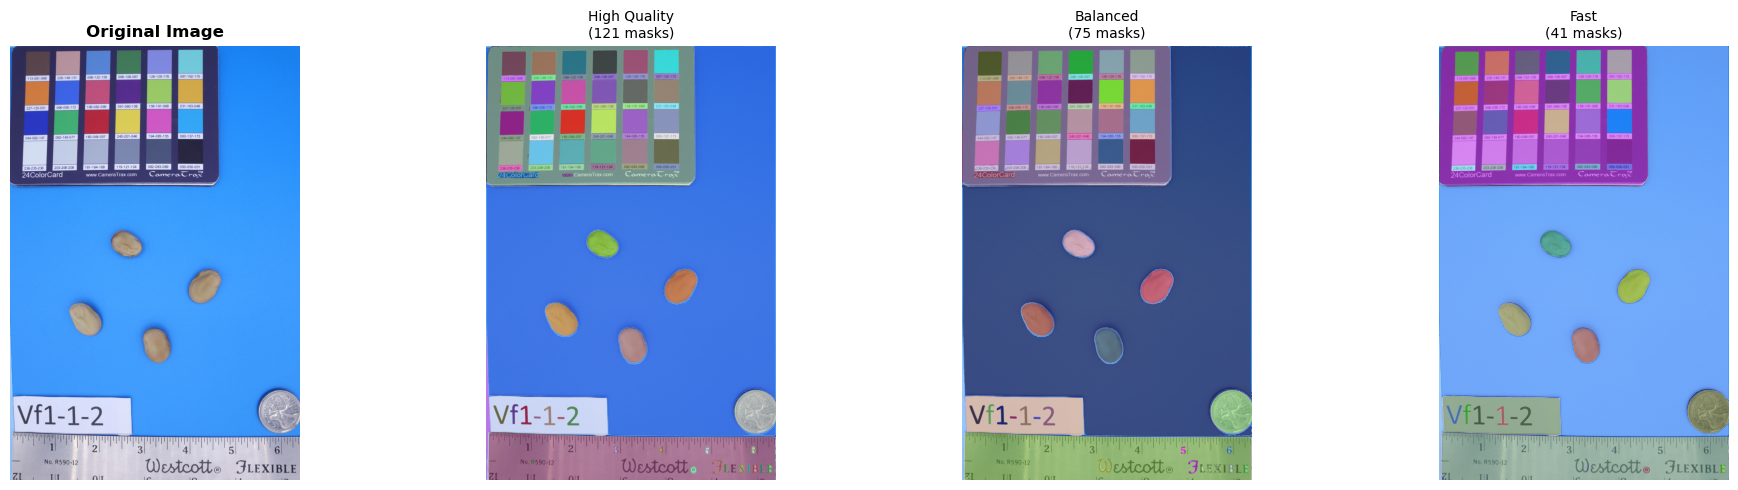

In [18]:
# Configuration 1: High Quality (more masks, slower)
mask_generator_hq = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.92,
    box_nms_thresh=0.7,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
)

# Configuration 2: Balanced (good quality, moderate speed)
mask_generator_balanced = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.90,
    box_nms_thresh=0.7,
    crop_n_layers=0,
    min_mask_region_area=200,
)

# Configuration 3: Fast (fewer masks, faster)
mask_generator_fast = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=16,
    pred_iou_thresh=0.90,
    stability_score_thresh=0.95,
    box_nms_thresh=0.7,
    crop_n_layers=0,
    min_mask_region_area=500,
)

# Generate masks with each configuration
configs = {
    "High Quality": mask_generator_hq,
    "Balanced": mask_generator_balanced,
    "Fast": mask_generator_fast
}

results_optimized = {}

for config_name, generator in configs.items():
    print(f"\nTesting {config_name} configuration...")
    start_time = time.time()
    masks = generator.generate(image)
    elapsed_time = time.time() - start_time
    
    results_optimized[config_name] = masks
    print(f"Generated {len(masks)} masks in {elapsed_time:.2f}s")

# Compare optimized configurations
compare_segmentations(image, results_optimized)

## 10. Performance Analysis


High Quality Statistics:
Number of masks: 121
Average area: 376506.12 pixels
Average stability score: 0.9739
Average predicted IoU: 0.9672

Balanced Statistics:
Number of masks: 75
Average area: 562263.20 pixels
Average stability score: 0.9707
Average predicted IoU: 0.9617

Fast Statistics:
Number of masks: 41
Average area: 840359.44 pixels
Average stability score: 0.9767
Average predicted IoU: 0.9705


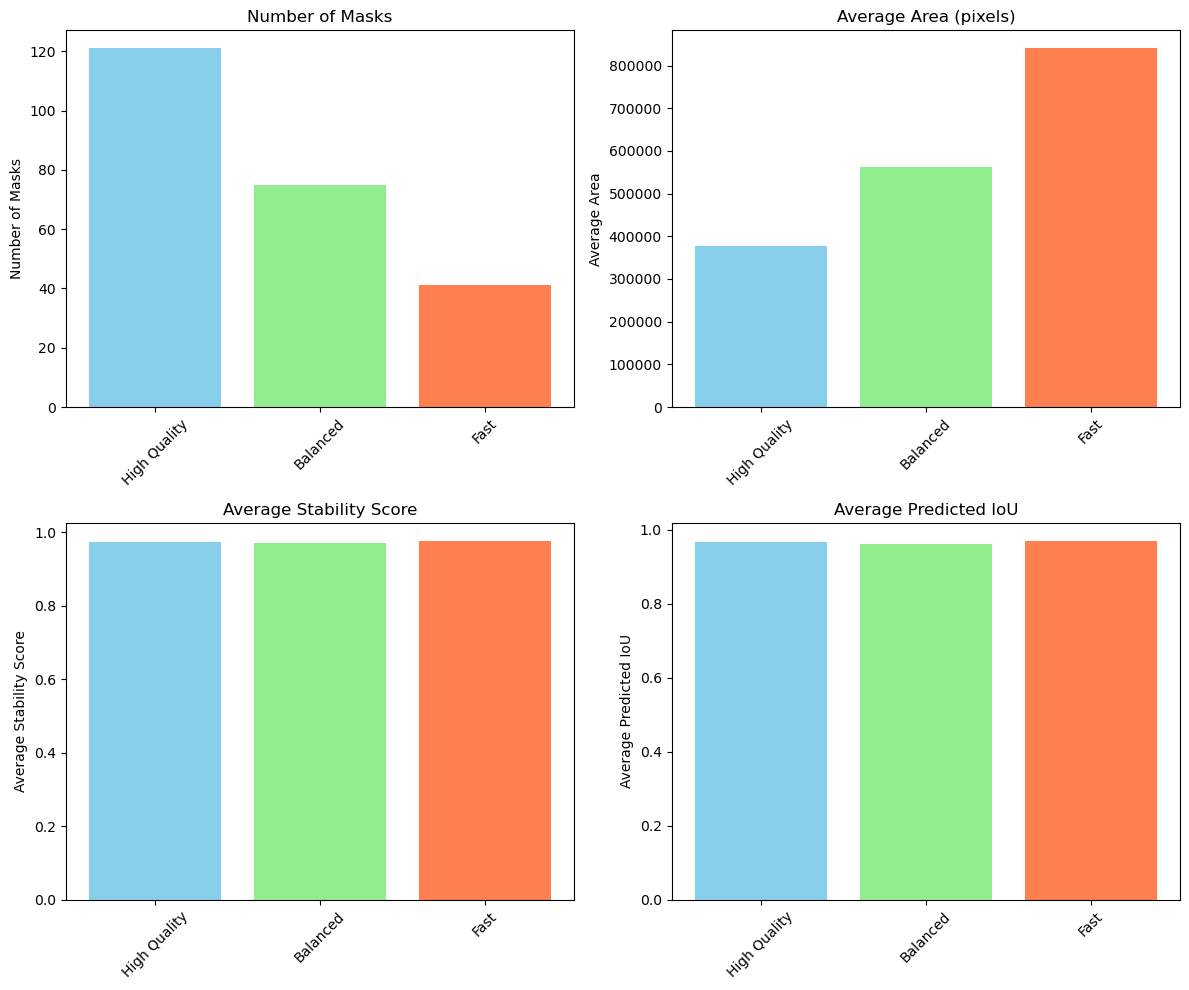

In [19]:
# Analyze mask statistics
def analyze_masks(masks, config_name):
    areas = [m['area'] for m in masks]
    stability_scores = [m['stability_score'] for m in masks]
    pred_ious = [m['predicted_iou'] for m in masks]
    
    print(f"\n{config_name} Statistics:")
    print(f"Number of masks: {len(masks)}")
    print(f"Average area: {np.mean(areas):.2f} pixels")
    print(f"Average stability score: {np.mean(stability_scores):.4f}")
    print(f"Average predicted IoU: {np.mean(pred_ious):.4f}")
    
    return {
        'count': len(masks),
        'avg_area': np.mean(areas),
        'avg_stability': np.mean(stability_scores),
        'avg_iou': np.mean(pred_ious)
    }

# Analyze all optimized configurations
stats = {}
for config_name, masks in results_optimized.items():
    stats[config_name] = analyze_masks(masks, config_name)

# Create comparison plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

configs_list = list(stats.keys())
metrics = ['count', 'avg_area', 'avg_stability', 'avg_iou']
titles = ['Number of Masks', 'Average Area (pixels)', 'Average Stability Score', 'Average Predicted IoU']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    values = [stats[config][metric] for config in configs_list]
    ax.bar(configs_list, values, color=['skyblue', 'lightgreen', 'coral'])
    ax.set_title(title)
    ax.set_ylabel(title.split('(')[0].strip())
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Save Results

In [20]:
# Save segmentation results
import json

def save_masks(masks, filename):
    """Save masks to a JSON file"""
    # Convert numpy arrays to lists for JSON serialization
    masks_serializable = []
    for mask in masks:
        mask_dict = {
            'segmentation': mask['segmentation'].tolist(),
            'area': int(mask['area']),
            'bbox': [int(x) for x in mask['bbox']],
            'predicted_iou': float(mask['predicted_iou']),
            'stability_score': float(mask['stability_score']),
        }
        masks_serializable.append(mask_dict)
    
    with open(filename, 'w') as f:
        json.dump(masks_serializable, f)
    print(f"Saved {len(masks)} masks to {filename}")

# Save visualization
def save_visualization(image, masks, filename):
    """Save visualization as image"""
    plt.figure(figsize=(15, 15))
    plt.imshow(image)
    show_anns(masks)
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.close()
    print(f"Saved visualization to {filename}")

# Save results for the balanced configuration
save_masks(results_optimized['Balanced'], 'masks_balanced.json')
save_visualization(image, results_optimized['Balanced'], 'segmentation_balanced.png')

print("\nResults saved successfully!")

Saved 75 masks to masks_balanced.json
Saved visualization to segmentation_balanced.png

Results saved successfully!


The evaluation of finetuning SAM 2.1 revealed that mask quality and computational efficiency are primarily governed by parameters controlling sampling density, confidence filtering, and redundancy suppression. 

Adjusting points_per_side enhanced segmentation detail, though at the expense of runtime; a setting of 32 points provided the most effective balance between accuracy and efficiency. In contrast, points_per_batch influenced only computational speed, with larger batch sizes reducing runtime without altering segmentation outcomes. Confidence-based thresholds—pred_iou_thresh and stability_score_thresh—had a pronounced effect on both the quantity and reliability of generated masks. Intermediate values (0.86 and 0.92, respectively) yielded the optimal trade-off, minimizing low-quality predictions while preserving meaningful segmentations. Redundancy control via box_nms_thresh also shaped performance: lower thresholds reduced overlap but risked discarding valid masks, whereas higher thresholds retained more masks at the cost of redundancy. An intermediate setting of 0.70 achieved the best compromise. By comparison, min_mask_region_area and crop_nms_thresh exerted little to no influence on segmentation results in this dataset, as all objects exceeded the minimum mask size and exhibited minimal overlap within cropped regions.